Files in ZIP:
TCGA_CS_4941_19960909/
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15_mask.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16_mask.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_mask.tif
TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18.tif
TCGA_C

Loading Images and Masks: 100%|██████████| 23/23 [00:00<00:00, 144.67it/s]


Loaded 23 images and 23 masks.


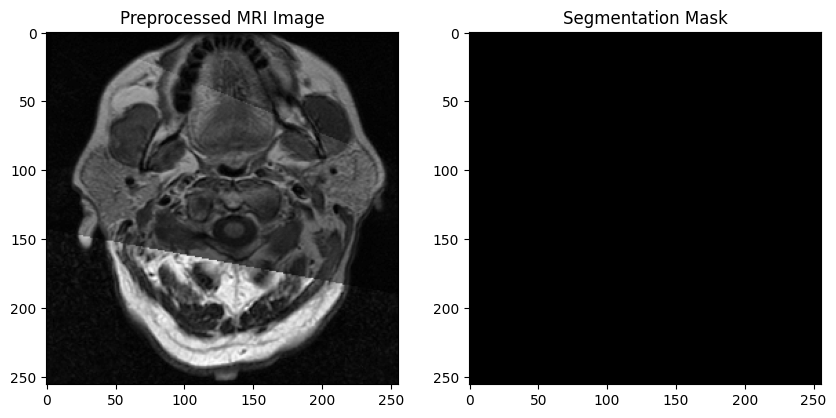

In [8]:
import zipfile
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def clahe_preprocess(img):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the MRI images.

    :param img: Input image (grayscale).
    :return: Image after applying CLAHE.
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def load_images_from_zip(zip_file_path, image_ext=".tif"):
    """
    Read images and corresponding masks directly from the ZIP file without extracting them to disk.

    :param zip_file_path: Path to the ZIP file containing MRI images and masks.
    :param image_ext: File extension of the images (default is .tif).
    :return: Two lists containing images and corresponding masks as NumPy arrays.
    """
    images = []
    masks = []

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # List all files in the ZIP
        zip_file_list = zip_ref.namelist()

        # Debug: print the list of files
        print("Files in ZIP:")
        for file in zip_file_list:
            print(file)

        # Filter out image and mask files (ignore _MACOSX and files starting with ".")
        image_files = sorted([f for f in zip_file_list if f.endswith(image_ext) and not '_MACOSX' in f and not f.startswith('.') and "mask" not in f])
        mask_files = sorted([f for f in zip_file_list if f.endswith(image_ext) and not '_MACOSX' in f and not f.startswith('.') and "mask" in f])

        # Debug: print the list of image and mask files being processed
        print(f"\nFound {len(image_files)} image files and {len(mask_files)} mask files:")
        print("Image files:", image_files)
        print("Mask files:", mask_files)

        # Check if image and mask counts match
        if len(image_files) != len(mask_files):
            print("Warning: Number of images and masks do not match!")

        # Read and process each image and its corresponding mask
        for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Loading Images and Masks"):
            # Read the image file from the ZIP
            with zip_ref.open(image_file) as img_file:
                img_data = img_file.read()
                img_array = np.frombuffer(img_data, np.uint8)
                img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
                preprocessed_img = clahe_preprocess(img)  # Apply CLAHE preprocessing
                images.append(preprocessed_img)

            # Read the mask file from the ZIP
            with zip_ref.open(mask_file) as mask_file:
                mask_data = mask_file.read()
                mask_array = np.frombuffer(mask_data, np.uint8)
                mask = cv2.imdecode(mask_array, cv2.IMREAD_GRAYSCALE)
                masks.append(mask)

    return np.array(images), np.array(masks)

# Example usage with the provided file path
zip_file_path = "/content/TCGA_CS_4941_19960909.zip"  # Provide the path to your ZIP file
X_images, Y_masks = load_images_from_zip(zip_file_path)

# Print to verify the number of images and masks loaded
print(f"Loaded {len(X_images)} images and {len(Y_masks)} masks.")

# Display the first image and its mask as an example
def display_example(X_images, Y_masks):
    """
    Display the first image and its mask using Matplotlib.

    :param X_images: List of preprocessed MRI images.
    :param Y_masks: List of segmentation masks.
    """
    if len(X_images) > 0 and len(Y_masks) > 0:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(X_images[0], cmap='gray')
        plt.title('Preprocessed MRI Image')

        plt.subplot(1, 2, 2)
        plt.imshow(Y_masks[0], cmap='gray')
        plt.title('Segmentation Mask')

        plt.show()
    else:
        print("No images or masks to display.")

# Display an example of the preprocessed image and mask
display_example(X_images, Y_masks)

In [9]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# CLAHE preprocessing
def clahe_preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

# Function to load images and masks from zip and preprocess
def load_images_from_zip(zip_file_path, image_ext=".tif"):
    images = []
    masks = []

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_file_list = zip_ref.namelist()
        image_files = sorted([f for f in zip_file_list if f.endswith(image_ext) and "mask" not in f])
        mask_files = sorted([f for f in zip_file_list if f.endswith(image_ext) and "mask" in f])

        for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Loading Images and Masks"):
            # Read the image file from the ZIP
            with zip_ref.open(image_file) as img_file:
                img_data = img_file.read()
                img_array = np.frombuffer(img_data, np.uint8)
                img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

                # Check if the image was decoded successfully
                if img is not None:
                    preprocessed_img = clahe_preprocess(img)
                    images.append(preprocessed_img)
                else:
                    print(f"Warning: Could not decode image file {image_file}, skipping.")

            # Read the mask file from the ZIP
            with zip_ref.open(mask_file) as mask_file:
                mask_data = mask_file.read()
                mask_array = np.frombuffer(mask_data, np.uint8)
                mask = cv2.imdecode(mask_array, cv2.IMREAD_GRAYSCALE)

                # Check if the mask was decoded successfully
                if mask is not None:
                    masks.append(mask)
                else:
                    print(f"Warning: Could not decode mask file {mask_file}, skipping.")

    return np.array(images), np.array(masks)

# Example usage
zip_file_path = "/content/TCGA_CS_4941_19960909.zip"
X_images, Y_masks = load_images_from_zip(zip_file_path)

# Data normalization and splitting (80% training, 20% testing)
X_images = X_images / 255.0  # Normalization
Y_masks = Y_masks / 255.0  # Normalize masks to range [0, 1]

X_train, X_test, Y_train, Y_test = train_test_split(X_images, Y_masks, test_size=0.2, random_state=42)

# Verifying the split
print(f"Training data: {len(X_train)} images, Testing data: {len(X_test)} images")

Loading Images and Masks: 100%|██████████| 23/23 [00:00<00:00, 297.84it/s]

Training data: 18 images, Testing data: 5 images


In [10]:
import tensorflow as tf
from tensorflow.keras import layers

def unet_pp(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Downsampling path
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Upsampling path
    up2 = layers.UpSampling2D(size=(4, 4))(pool2)  # Upsample back to 256x256
    up2_conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)

    # Concatenate the upsampled feature map with the corresponding downsampled feature map
    merge2 = layers.Concatenate(axis=3)([conv1, up2_conv])

    conv_final = layers.Conv2D(1, (1, 1), activation='sigmoid')(merge2)

    model = tf.keras.Model(inputs=inputs, outputs=conv_final)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

    return model

unetpp_model = unet_pp()
unetpp_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 256, 256, 128)  │              0 │ max_pooling2d_1[0][0]  │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         73,792 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 128)  │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 1)    │            129 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 148,417 (579.75 KB)

 Trainable params: 148,417 (579.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Data Preprocessing and Loading Functions
def clahe_preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def load_images_from_zip(zip_file_path, image_ext=".tif"):
    images = []
    masks = []

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_file_list = zip_ref.namelist()
        image_files = sorted([f for f in zip_file_list if f.endswith(image_ext) and "mask" not in f])
        mask_files = sorted([f for f in zip_file_list if f.endswith(image_ext) and "mask" in f])

        for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Loading Images and Masks"):
            # Read and preprocess image
            with zip_ref.open(image_file) as img_file:
                img_data = img_file.read()
                img_array = np.frombuffer(img_data, np.uint8)
                img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    preprocessed_img = clahe_preprocess(img)
                    images.append(preprocessed_img)
                else:
                    print(f"Warning: Could not decode image file {image_file}, skipping.")

            # Read mask
            with zip_ref.open(mask_file) as mask_file:
                mask_data = mask_file.read()
                mask_array = np.frombuffer(mask_data, np.uint8)
                mask = cv2.imdecode(mask_array, cv2.IMREAD_GRAYSCALE)

                if mask is not None:
                    masks.append(mask)
                else:
                    print(f"Warning: Could not decode mask file {mask_file}, skipping.")

    return np.array(images), np.array(masks)

# Model Architectures
def unet_pp(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Downsampling path
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Upsampling path
    up2 = layers.UpSampling2D(size=(4, 4))(pool2)  # Upsample back to 256x256
    up2_conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)

    # Concatenate the upsampled feature map with the corresponding downsampled feature map
    merge2 = layers.Concatenate(axis=3)([conv1, up2_conv])

    conv_final = layers.Conv2D(1, (1, 1), activation='sigmoid')(merge2)

    model = Model(inputs=inputs, outputs=conv_final)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

    return model

def attention_gate(x, g, inter_channel):
    theta_x = layers.Conv2D(inter_channel, (1, 1), use_bias=False)(x)
    phi_g = layers.Conv2D(inter_channel, (1, 1), use_bias=False)(g)

    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, (1, 1), use_bias=False)(f)

    rate = layers.Activation('sigmoid')(psi_f)
    att_x = layers.multiply([x, rate])

    return att_x

def attention_unet(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up2 = layers.UpSampling2D(size=(2, 2))(conv3)
    att2 = attention_gate(conv2, up2, 128)
    up2 = layers.concatenate([up2, att2])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up1 = layers.UpSampling2D(size=(2, 2))(conv4)
    att1 = attention_gate(conv1, up1, 64)
    up1 = layers.concatenate([up1, att1])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up1)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

    return model

# Model Training and Evaluation
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-7)

def train_and_evaluate(model, X_train, Y_train, X_test, Y_test, model_name, epochs=50, batch_size=32):
    checkpoint = ModelCheckpoint(
        f"{model_name}_best.keras",
        monitor='val_mean_io_u',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    early_stopping = EarlyStopping(monitor='val_mean_io_u', mode='max', patience=10, verbose=1)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping]
    )

    # Evaluate the model
    model.load_weights(f"{model_name}_best.keras")
    test_loss, test_iou = model.evaluate(X_test, Y_test)
    test_dice = dice_coefficient(Y_test, model.predict(X_test))

    print(f"{model_name} Test IoU: {test_iou}")
    print(f"{model_name} Test Dice Score: {test_dice}")

    return history, test_iou, test_dice

# Main execution
if _name_ == "_main_":
    # Load and preprocess data
    zip_file_path = "/content/TCGA_CS_4941_19960909.zip"
    X_images, Y_masks = load_images_from_zip(zip_file_path)

    # Data normalization and splitting
    X_images = X_images / 255.0
    Y_masks = Y_masks / 255.0

    X_train, X_test, Y_train, Y_test = train_test_split(X_images, Y_masks, test_size=0.2, random_state=42)

    print(f"Training data: {len(X_train)} images, Testing data: {len(X_test)} images")

    # Train and evaluate U-Net++
    unetpp_model = unet_pp()
    unetpp_history, unetpp_iou, unetpp_dice = train_and_evaluate(unetpp_model, X_train, Y_train, X_test, Y_test, "unetpp")

    # Train and evaluate Attention U-Net
    attention_unet_model = attention_unet()
    attention_unet_history, attention_unet_iou, attention_unet_dice = train_and_evaluate(attention_unet_model, X_train, Y_train, X_test, Y_test, "attention_unet")

    # Compare model performances
    print("\nModel Comparison:")
    print(f"U-Net++ IoU: {unetpp_iou}, Dice Score: {unetpp_dice}")
    print(f"Attention U-Net IoU: {attention_unet_iou}, Dice Score: {attention_unet_dice}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(unetpp_history.history['mean_io_u'], label='U-Net++ Train IoU')
    plt.plot(unetpp_history.history['val_mean_io_u'], label='U-Net++ Val IoU')
    plt.plot(attention_unet_history.history['mean_io_u'], label='Attention U-Net Train IoU')
    plt.plot(attention_unet_history.history['val_mean_io_u'], label='Attention U-Net Val IoU')
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(122)
    plt.plot(unetpp_history.history['loss'], label='U-Net++ Train Loss')
    plt.plot(unetpp_history.history['val_loss'], label='U-Net++ Val Loss')
    plt.plot(attention_unet_history.history['loss'], label='Attention U-Net Train Loss')
    plt.plot(attention_unet_history.history['val_loss'], label='Attention U-Net Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [13]:
# Data Preprocessing and Loading Functions
def clahe_preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def load_images_from_zip(zip_file_path, image_ext=".tif"):
    images = []
    masks = []

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_file_list = zip_ref.namelist()
        image_files = sorted([f for f in zip_file_list if f.endswith(image_ext) and "mask" not in f])
        mask_files = sorted([f for f in zip_file_list if f.endswith(image_ext) and "mask" in f])

        for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Loading Images and Masks"):
            # Read and preprocess image
            with zip_ref.open(image_file) as img_file:
                img_data = img_file.read()
                img_array = np.frombuffer(img_data, np.uint8)
                img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    preprocessed_img = clahe_preprocess(img)
                    images.append(preprocessed_img)
                else:
                    print(f"Warning: Could not decode image file {image_file}, skipping.")

            # Read mask
            with zip_ref.open(mask_file) as mask_file:
                mask_data = mask_file.read()
                mask_array = np.frombuffer(mask_data, np.uint8)
                mask = cv2.imdecode(mask_array, cv2.IMREAD_GRAYSCALE)

                if mask is not None:
                    masks.append(mask)
                else:
                    print(f"Warning: Could not decode mask file {mask_file}, skipping.")

    return np.array(images), np.array(masks)


In [14]:
# Model Architectures
def unet_pp(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Downsampling path
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Upsampling path
    up2 = layers.UpSampling2D(size=(4, 4))(pool2)  # Upsample back to 256x256
    up2_conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)

    # Concatenate the upsampled feature map with the corresponding downsampled feature map
    merge2 = layers.Concatenate(axis=3)([conv1, up2_conv])

    conv_final = layers.Conv2D(1, (1, 1), activation='sigmoid')(merge2)

    model = Model(inputs=inputs, outputs=conv_final)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

    return model

def attention_gate(x, g, inter_channel):
    theta_x = layers.Conv2D(inter_channel, (1, 1), use_bias=False)(x)
    phi_g = layers.Conv2D(inter_channel, (1, 1), use_bias=False)(g)

    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, (1, 1), use_bias=False)(f)

    rate = layers.Activation('sigmoid')(psi_f)
    att_x = layers.multiply([x, rate])

    return att_x

def attention_unet(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up2 = layers.UpSampling2D(size=(2, 2))(conv3)
    att2 = attention_gate(conv2, up2, 128)
    up2 = layers.concatenate([up2, att2])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up1 = layers.UpSampling2D(size=(2, 2))(conv4)
    att1 = attention_gate(conv1, up1, 64)
    up1 = layers.concatenate([up1, att1])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up1)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

    return model


In [15]:
# Model Training and Evaluation
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-7)

def train_and_evaluate(model, X_train, Y_train, X_test, Y_test, model_name, epochs=50, batch_size=32):
    checkpoint = ModelCheckpoint(
        f"{model_name}_best.keras",
        monitor='val_mean_io_u',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    early_stopping = EarlyStopping(monitor='val_mean_io_u', mode='max', patience=10, verbose=1)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping]
    )

    # Evaluate the model
    model.load_weights(f"{model_name}_best.keras")
    test_loss, test_iou = model.evaluate(X_test, Y_test)
    test_dice = dice_coefficient(Y_test, model.predict(X_test))

    print(f"{model_name} Test IoU: {test_iou}")
    print(f"{model_name} Test Dice Score: {test_dice}")

    return history, test_iou, test_dice

In [18]:
# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    zip_file_path = "/content/TCGA_CS_4941_19960909.zip"
    X_images, Y_masks = load_images_from_zip(zip_file_path)

    # Data normalization and splitting
    X_images = X_images / 255.0
    Y_masks = Y_masks / 255.0

    X_train, X_test, Y_train, Y_test = train_test_split(X_images, Y_masks, test_size=0.2, random_state=42) # Call the correct function train_test_split

Loading Images and Masks: 100%|██████████| 23/23 [00:00<00:00, 148.16it/s]
